In [3]:
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random
import time

### Load data

In [ ]:
!wget --random-wait -i ../data/georges.csv -P ../data/images/georges
!wget --random-wait -i ../data/non_georges.csv -P ../data/images/non_georges

#### Remove dublicates

In [ ]:
!rm ../data/images/*/*.1
!rm ../data/images/*/*.2
!rm ../data/images/*/*.3

#### Visualize a few images

In [ ]:
fig = plt.figure(figsize=(16, 17))
axes = []
path = '../data/images/georges'
for i, img_name in zip(np.arange(1, 21), os.listdir(path)[:20]):
    axes.append(fig.add_subplot(4, 5, i))
    subplot_title = ('Image' + str(i))
    axes[-1].set_title(subplot_title) 
    img_path = os.path.join(path, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

In [ ]:
fig = plt.figure(figsize=(16, 17))
axes = []
path = '../data/images/non_georges'
for i, img_name in zip(np.arange(1, 21), os.listdir(path)[:20]):
    axes.append(fig.add_subplot(4, 5, i))
    subplot_title = ('Image' + str(i))
    axes[-1].set_title(subplot_title) 
    img_path = os.path.join(path, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

### Define training parameters

In [23]:
params = {
    'model': 'resnet50',
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'lr': 0.0005,
    'batch_size': 64,
    'num_workers': 16,
    'num_epochs': 25,
    'train_size': 0.7,
    'feature_extract': False,
    'num_classes': 2,
    'input_size': 224,
    'momentum': 0.9    
}

In [24]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

### Define and initialize model

Pretrained Resnet-50 + 1 extra fully connected layer. I freeze layers 1-6 in the total 10 layers of Resnet50. 



In [25]:
model = getattr(models, params['model'])(pretrained=True)

if params['feature_extract']:
    for param in model.parameters():
        param.requires_grad = False
else:
    ct = 0
    for child in model.children():
        ct += 1
        if ct < 7:
            for param in child.parameters():
                param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_ftrs)
model = nn.Sequential(
    model,
    nn.ReLU(),
    nn.Linear(num_ftrs, params['num_classes'])
)
model = model.to(params['device'])

In [26]:
print(model)

Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

### Setup transforms, datasets, and dataloaders

In [27]:
class GeorgeVsNonGeorgeDataset(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if os.path.normpath(image_filepath).split(os.sep)[-2] == 'georges':
            label = 1
        else:
            label = 0
        if self.transform is not None:
            image = self.transform(image=image)['image']
        return image, label

In [28]:
root_directory = '../data/images'

geo_directory = os.path.join(root_directory, 'georges')
nongeo_directory = os.path.join(root_directory, 'non_georges')

geo_images_paths = sorted([os.path.join(geo_directory, f) for f in os.listdir(geo_directory)])
nongeo_images_paths = sorted([os.path.join(nongeo_directory, f) for f in os.listdir(nongeo_directory)])
images_paths = [*geo_images_paths, *nongeo_images_paths]

num_imgs = len(images_paths)
indices = list(range(num_imgs))
class_names = ['non_georges', 'georges']

np.random.shuffle(images_paths)

split = int(params['train_size'] * num_imgs)
split2 = int((split + num_imgs) / 2)
train_paths, val_paths, test_paths = images_paths[:split], images_paths[split:split2], images_paths[split2:]

In [29]:
train_trans = A.Compose(
    [
        A.SmallestMaxSize(max_size=300),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=params['input_size'], width=params['input_size']),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

val_trans = A.Compose(
    [
        A.SmallestMaxSize(max_size=300),
        A.CenterCrop(height=params['input_size'], width=params['input_size']),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

train_data = GeorgeVsNonGeorgeDataset(images_filepaths=train_paths, transform=train_trans)
val_data = GeorgeVsNonGeorgeDataset(images_filepaths=val_paths, transform=val_trans)
test_data = GeorgeVsNonGeorgeDataset(images_filepaths=test_paths, transform=val_trans)

dataloaders_dict = {'train' : DataLoader(
    train_data, batch_size=params['batch_size'], shuffle=True, num_workers=params['num_workers']
),
                    'val': DataLoader(
    val_data, batch_size=params['batch_size'], shuffle=False, num_workers=params['num_workers']
),
                    'test': DataLoader(
    test_data, batch_size=params['batch_size'], shuffle=False, num_workers=params['num_workers']
)
                   }

### Create the optimizer and criterion

In [30]:
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer = optim.SGD(params_to_update, lr=params['lr'], momentum=params['momentum'])

In [31]:
criterion = nn.CrossEntropyLoss()

### Train and evaluate

In [32]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    since = time.time()

    history = {
        'train_acc': [],
        'train_loss': [],
        'val_acc': [],
        'val_loss': []
    }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(params['device'])
                labels = labels.to(params['device'])

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'train':
                history['train_acc'].append(epoch_acc)
                history['train_loss'].append(epoch_loss)
            if phase == 'val':
                history['val_acc'].append(epoch_acc)
                history['val_loss'].append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model, history

In [33]:
def visualize_images(model, num_images=6):
    mean = np.array([0.485, 0.456, 0.406])
    std =  np.array([0.229, 0.224, 0.225])
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(16, 17))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders_dict['test']):
            inputs = inputs.to(params['device'])
            labels = labels.to(params['device'])

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}, true label: {class_names[labels[j]]}')
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0)) * std + mean
                img = np.clip(img, 0, 1)
                plt.imshow(img)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
        
def build_val_curves(hist):
    epochs = np.arange(1, params['num_epochs'] + 1)
    plt.figure()
    plt.plot(epochs, hist['train_acc'], label='train')
    plt.plot(epochs, hist['val_acc'], label='validation')
    plt.grid()
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('model accuracy')
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(epochs, hist['train_loss'], label='train')
    plt.plot(epochs, hist['val_loss'], label='validation')
    plt.grid()
    plt.xlabel('epoch')
    plt.ylabel('model loss')
    plt.title('loss curves')
    plt.legend()
    plt.show()

In [34]:
model, hist = train_model(model, dataloaders_dict, criterion,
                          optimizer, num_epochs=params['num_epochs']
                         )

Epoch 1/25
----------
train Loss: 0.6542 Acc: 0.6144
val Loss: 0.5915 Acc: 0.7520

Epoch 2/25
----------
train Loss: 0.5687 Acc: 0.7395
val Loss: 0.5002 Acc: 0.8129

Epoch 3/25
----------
train Loss: 0.4875 Acc: 0.7932
val Loss: 0.4229 Acc: 0.8281

Epoch 4/25
----------
train Loss: 0.4220 Acc: 0.8167
val Loss: 0.3628 Acc: 0.8491

Epoch 5/25
----------
train Loss: 0.3616 Acc: 0.8478
val Loss: 0.3225 Acc: 0.8667

Epoch 6/25
----------
train Loss: 0.3293 Acc: 0.8634
val Loss: 0.2987 Acc: 0.8643

Epoch 7/25
----------
train Loss: 0.2929 Acc: 0.8827
val Loss: 0.2862 Acc: 0.8784

Epoch 8/25
----------
train Loss: 0.2590 Acc: 0.8935
val Loss: 0.2682 Acc: 0.8830

Epoch 9/25
----------
train Loss: 0.2488 Acc: 0.9000
val Loss: 0.2526 Acc: 0.8947

Epoch 10/25
----------
train Loss: 0.2310 Acc: 0.9032
val Loss: 0.2508 Acc: 0.8947

Epoch 11/25
----------
train Loss: 0.2044 Acc: 0.9210
val Loss: 0.2423 Acc: 0.8971

Epoch 12/25
----------
train Loss: 0.1974 Acc: 0.9208
val Loss: 0.2385 Acc: 0.9006

E

In [35]:
correct = 0
total = 0
with torch.no_grad():
    for data in dataloaders_dict['test']:
        inputs, labels = data
        inputs = inputs.to(params['device'])
        labels = labels.to(params['device'])
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on test images: {100 * correct / total}')

Accuracy of the network on test images: 90.88785046728972


In [ ]:
visualize_images(model, 12)

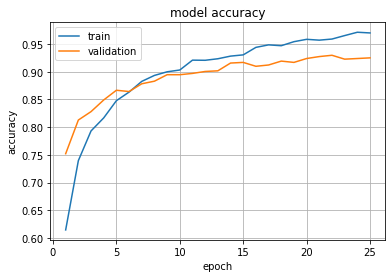

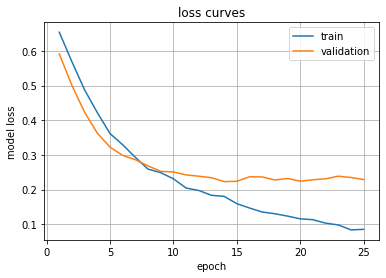

In [37]:
build_val_curves(hist)

In [38]:
torch.save(model.state_dict(), '../models/resnet50-half-trained.pt')